# Lab 5

In [1]:
import pandas as pd
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/company-bankruptcy-prediction")

print("Path to dataset files:", path)
df = pd.read_csv(path + '/data.csv')

100%|██████████| 4.63M/4.63M [00:00<00:00, 78.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/company-bankruptcy-prediction/versions/2


# 1. Exploratory Data Analysis (EDA)

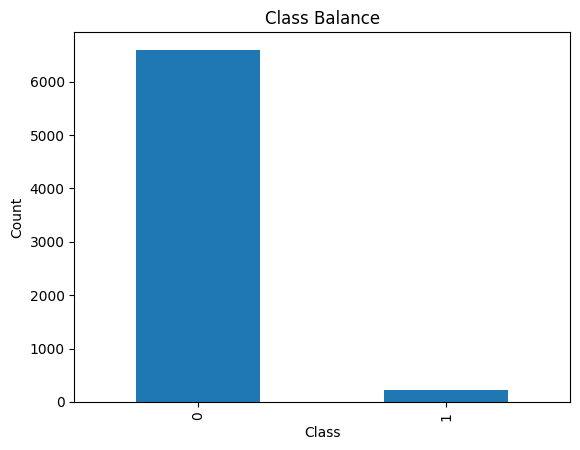

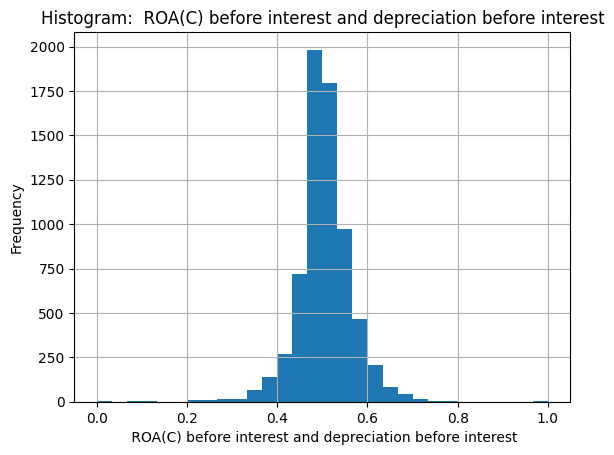

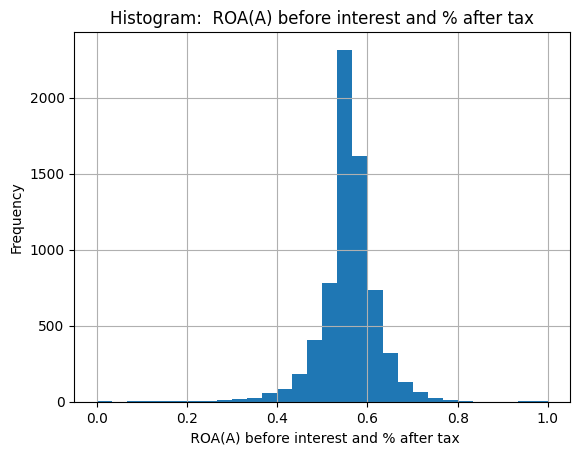

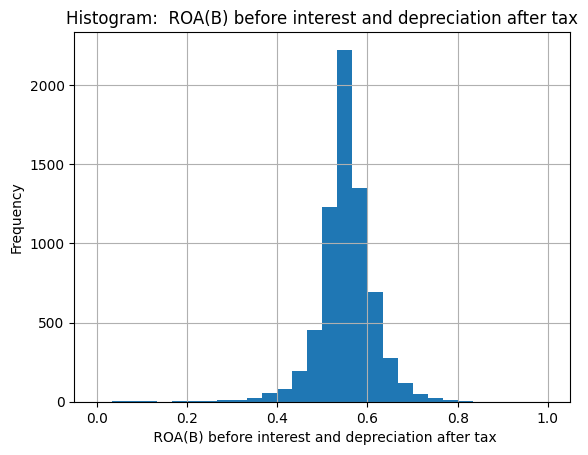

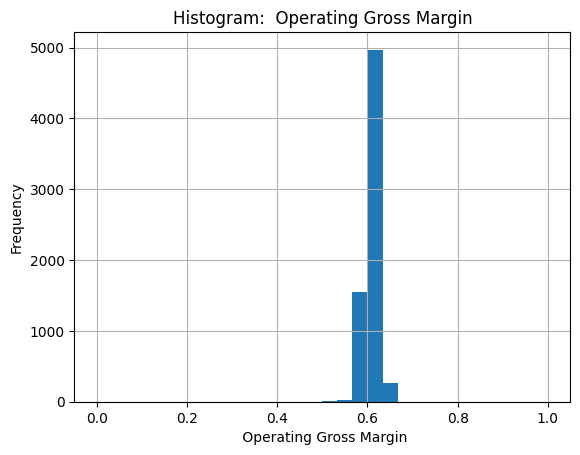

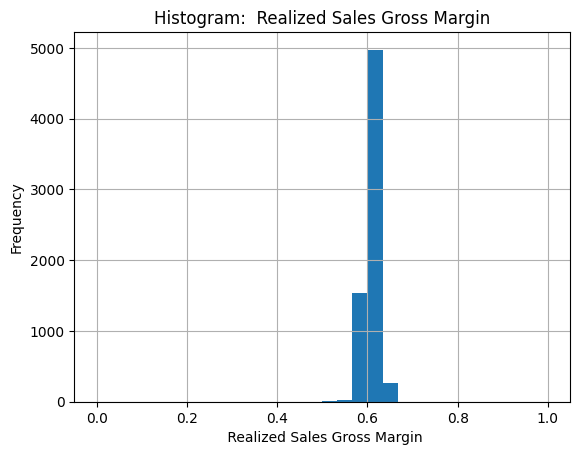

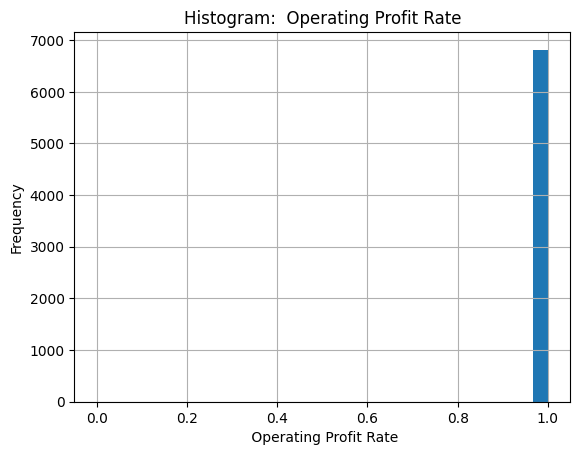

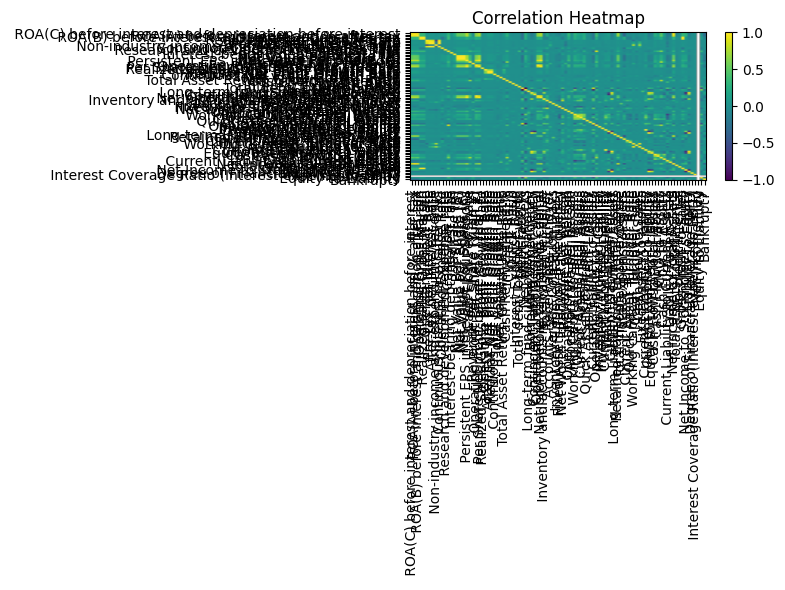

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
target = 'Bankrupt?'
feature_cols = [c for c in df.columns if c != target]

# Class balance bar chart
plt.figure()
df[target].value_counts().plot(kind='bar')
plt.title("Class Balance")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Histograms for first 6 features
for col in feature_cols[:6]:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Correlation heatmap using matplotlib only
corr = df[feature_cols + [target]].corr(numeric_only=True)
plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto')
plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
plt.yticks(range(corr.shape[0]), corr.index)
plt.title("Correlation Heatmap")
plt.colorbar()
plt.tight_layout()
plt.show()


# 2. Data Preprocessing

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler

X = df[feature_cols]
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

num_pipe_lr = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])
num_pipe_tree = Pipeline([('imputer', SimpleImputer(strategy='median'))])

pre_lr = ColumnTransformer([('num', num_pipe_lr, feature_cols)])
pre_tree = ColumnTransformer([('num', num_pipe_tree, feature_cols)])

sampler = RandomOverSampler(random_state=42)


# 3. Feature Selection

In [4]:
from xgboost import XGBClassifier

xgb_temp = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, eval_metric='logloss')
xgb_temp.fit(X_train, y_train)
importances = pd.Series(xgb_temp.feature_importances_, index=feature_cols)
selected_features = importances[importances > importances.median()].index.tolist()
if len(selected_features) < 5:
    selected_features = importances.sort_values(ascending=False).head(15).index.tolist()

print(f"Selected {len(selected_features)} features.")
X_train = X_train[selected_features]
X_test = X_test[selected_features]
pre_lr = ColumnTransformer([('num', num_pipe_lr, selected_features)])
pre_tree = ColumnTransformer([('num', num_pipe_tree, selected_features)])


Selected 47 features.


# 4 Hyperparameter Tuning

In [5]:
# Install Hyperopt
!pip -q install hyperopt

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Markdown, display

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
best_params = {}
best_scores = {}

# Logistic Regression search space and objective
space_lr = {
    'C': hp.loguniform('lr_C', np.log(0.001), np.log(10.0)),
    'solver': hp.choice('lr_solver', ['liblinear', 'lbfgs'])
}
def objective_lr(p):
    model = Pipeline([('pre', pre_lr),
                      ('clf', LogisticRegression(max_iter=500, class_weight='balanced', C=p['C'], solver=p['solver']))])
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}
trials_lr = Trials()
best_lr = fmin(fn=objective_lr, space=space_lr, algo=tpe.suggest, max_evals=20, trials=trials_lr, rstate=np.random.default_rng(42))
best_lr_resolved = space_eval(space_lr, best_lr)
best_params['Logistic Regression'] = best_lr_resolved
best_scores['Logistic Regression'] = -min([t['result']['loss'] for t in trials_lr.trials])

# Random Forest search space and objective
space_rf = {
    'n_estimators': hp.choice('rf_n_estimators', [100, 200, 300]),
    'max_depth': hp.choice('rf_max_depth', [None, 5, 10, 15]),
    'min_samples_split': hp.choice('rf_min_samples_split', [2, 5, 10])
}
def objective_rf(p):
    model = Pipeline([('pre', pre_tree),
                      ('clf', RandomForestClassifier(class_weight='balanced', random_state=42,
                                                    n_estimators=p['n_estimators'],
                                                    max_depth=p['max_depth'],
                                                    min_samples_split=p['min_samples_split']))])
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}
trials_rf = Trials()
best_rf = fmin(fn=objective_rf, space=space_rf, algo=tpe.suggest, max_evals=20, trials=trials_rf, rstate=np.random.default_rng(42))
best_rf_resolved = space_eval(space_rf, best_rf)
best_params['Random Forest'] = best_rf_resolved
best_scores['Random Forest'] = -min([t['result']['loss'] for t in trials_rf.trials])

# XGBoost search space and objective
space_xgb = {
    'n_estimators': hp.choice('xgb_n_estimators', [100, 200, 300]),
    'max_depth': hp.choice('xgb_max_depth', [3, 4, 5]),
    'learning_rate': hp.uniform('xgb_learning_rate', 0.01, 0.3)
}
def objective_xgb(p):
    model = Pipeline([('pre', pre_tree),
                      ('clf', XGBClassifier(random_state=42, eval_metric='logloss',
                                            n_estimators=p['n_estimators'],
                                            max_depth=p['max_depth'],
                                            learning_rate=p['learning_rate']))])
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}
trials_xgb = Trials()
best_xgb = fmin(fn=objective_xgb, space=space_xgb, algo=tpe.suggest, max_evals=20, trials=trials_xgb, rstate=np.random.default_rng(42))
best_xgb_resolved = space_eval(space_xgb, best_xgb)
best_params['XGBoost'] = best_xgb_resolved
best_scores['XGBoost'] = -min([t['result']['loss'] for t in trials_xgb.trials])

# Summary with actual best params and scores
md = "# Hyperparameter Tuning Summary (Hyperopt)\n\n"
md += "- Optimization: TPE (Tree-structured Parzen Estimator), 3-fold StratifiedKFold, scoring=ROC-AUC.\n"
md += "- Max evaluations per model: 20.\n\n"
for name in ['Logistic Regression', 'Random Forest', 'XGBoost']:
    md += f"**{name}**\n\n"
    md += f"- Best params: `{best_params[name]}`\n"
    md += f"- Mean CV ROC-AUC (best): `{best_scores[name]:.4f}`\n\n"
display(Markdown(md))

100%|██████████| 20/20 [00:37<00:00,  1.86s/trial, best loss: -0.9365228543947947]


# Hyperparameter Tuning Summary (Hyperopt)

- Optimization: TPE (Tree-structured Parzen Estimator), 3-fold StratifiedKFold, scoring=ROC-AUC.
- Max evaluations per model: 20.

**Logistic Regression**

- Best params: `{'C': 0.007061036687172371, 'solver': 'lbfgs'}`
- Mean CV ROC-AUC (best): `0.9241`

**Random Forest**

- Best params: `{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 300}`
- Mean CV ROC-AUC (best): `0.9374`

**XGBoost**

- Best params: `{'learning_rate': 0.021965503637564686, 'max_depth': 3, 'n_estimators': 100}`
- Mean CV ROC-AUC (best): `0.9365`



# 5. Model Training

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# Pipelines with tuned params using ImbPipeline
lr_model = ImbPipeline([('pre', pre_lr), ('sampler', sampler),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced',
                               C=best_params['Logistic Regression']['C'],
                               solver=best_params['Logistic Regression']['solver']))])

rf_model = ImbPipeline([('pre', pre_tree), ('sampler', sampler),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42,
                                   n_estimators=best_params['Random Forest']['n_estimators'],
                                   max_depth=best_params['Random Forest']['max_depth'],
                                   min_samples_split=best_params['Random Forest']['min_samples_split']))])

xgb_model = ImbPipeline([('pre', pre_tree), ('sampler', sampler),
    ('clf', XGBClassifier(random_state=42, eval_metric='logloss',
                          n_estimators=best_params['XGBoost']['n_estimators'],
                          max_depth=best_params['XGBoost']['max_depth'],
                          learning_rate=best_params['XGBoost']['learning_rate']))])

# Fit on training data
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  [' ROA(C) before interest '
                                                   'and depreciation before '
                                                   'interest',
                                                   ' ROA(A) before interest '
                                                   'and % after tax',
                                                   ' ROA(B) before interest '
                                                   'and depreciation after tax',
                                                   ' Operating Gross Margin',
                                                   ' Pre-tax net Interest Rate',
                                                   ' Non-industry income and '
                                                   'expenditure...
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.021965503637564686, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])

# 6. Model Evaluation and Comparison

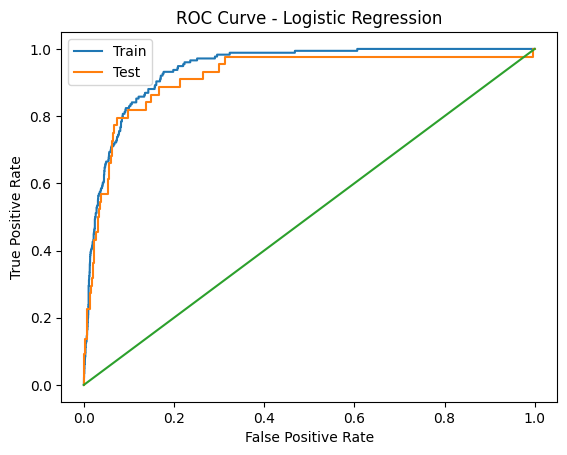

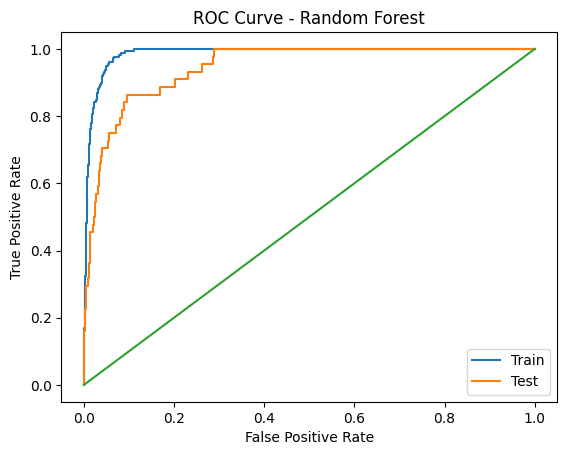

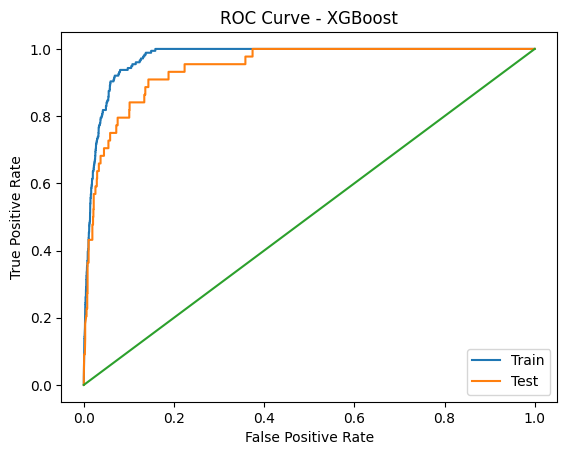

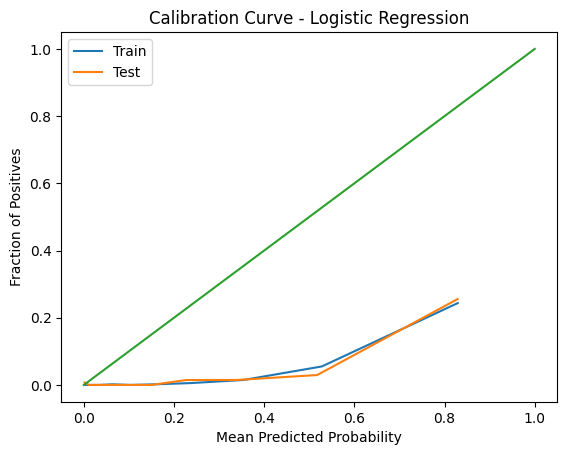

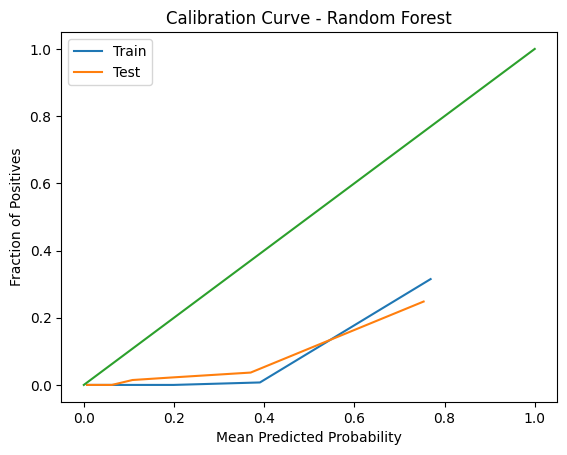

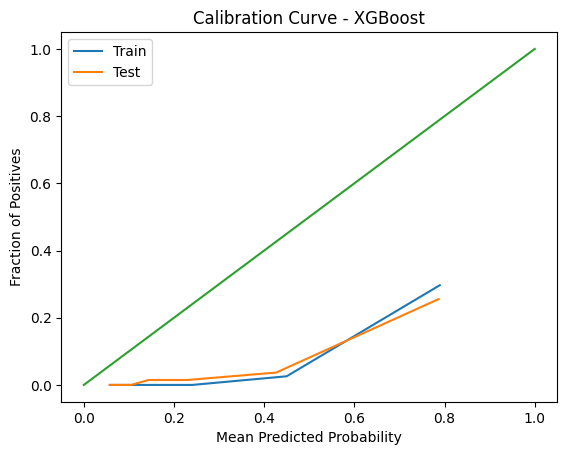

,Model,ROC_AUC_Train,ROC_AUC_Test,Brier_Train,Brier_Test,F1_Train,F1_Test
1,Random Forest,0.986790,0.945179,0.059172,0.064589,0.447607,0.366492
2,XGBoost,0.974823,0.944421,0.075802,0.077753,0.370536,0.336538
0,Logistic Regression,0.941128,0.917028,0.102364,0.101167,0.287324,0.276923


In [7]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, brier_score_loss, roc_curve
from sklearn.calibration import calibration_curve

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
models = {'Logistic Regression': lr_model, 'Random Forest': rf_model, 'XGBoost': xgb_model}
metrics = []

# Mean CV ROC-AUC and train for final evaluation
for name, model in models.items():
    cv_score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    model.fit(X_train, y_train)
    p_tr = model.predict_proba(X_train)[:, 1]
    p_te = model.predict_proba(X_test)[:, 1]
    metrics.append({
        'Model': name,
        #'CV_ROC_AUC': cv_score,
        'ROC_AUC_Train': roc_auc_score(y_train, p_tr),
        'ROC_AUC_Test': roc_auc_score(y_test, p_te),
        'Brier_Train': brier_score_loss(y_train, p_tr),
        'Brier_Test': brier_score_loss(y_test, p_te),
        'F1_Train': f1_score(y_train, (p_tr >= 0.5).astype(int)),
        'F1_Test': f1_score(y_test, (p_te >= 0.5).astype(int))
    })
    fpr_tr, tpr_tr, _ = roc_curve(y_train, p_tr)
    fpr_te, tpr_te, _ = roc_curve(y_test, p_te)
    plt.figure()
    plt.plot(fpr_tr, tpr_tr, label="Train")
    plt.plot(fpr_te, tpr_te, label="Test")
    plt.plot([0,1],[0,1])
    plt.title(f"ROC Curve - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# Calibration curves (one chart per model)
for name, model in models.items():
    p_tr = model.predict_proba(X_train)[:, 1]
    p_te = model.predict_proba(X_test)[:, 1]
    prob_true_tr, prob_pred_tr = calibration_curve(y_train, p_tr, n_bins=10, strategy='quantile')
    prob_true_te, prob_pred_te = calibration_curve(y_test, p_te, n_bins=10, strategy='quantile')
    plt.figure()
    plt.plot(prob_pred_tr, prob_true_tr, label="Train")
    plt.plot(prob_pred_te, prob_true_te, label="Test")
    plt.plot([0,1],[0,1])
    plt.title(f"Calibration Curve - {name}")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.show()

metrics_df = pd.DataFrame(metrics).sort_values('ROC_AUC_Test', ascending=False)
metrics_df


# 7. SHAP Values for Interpretability

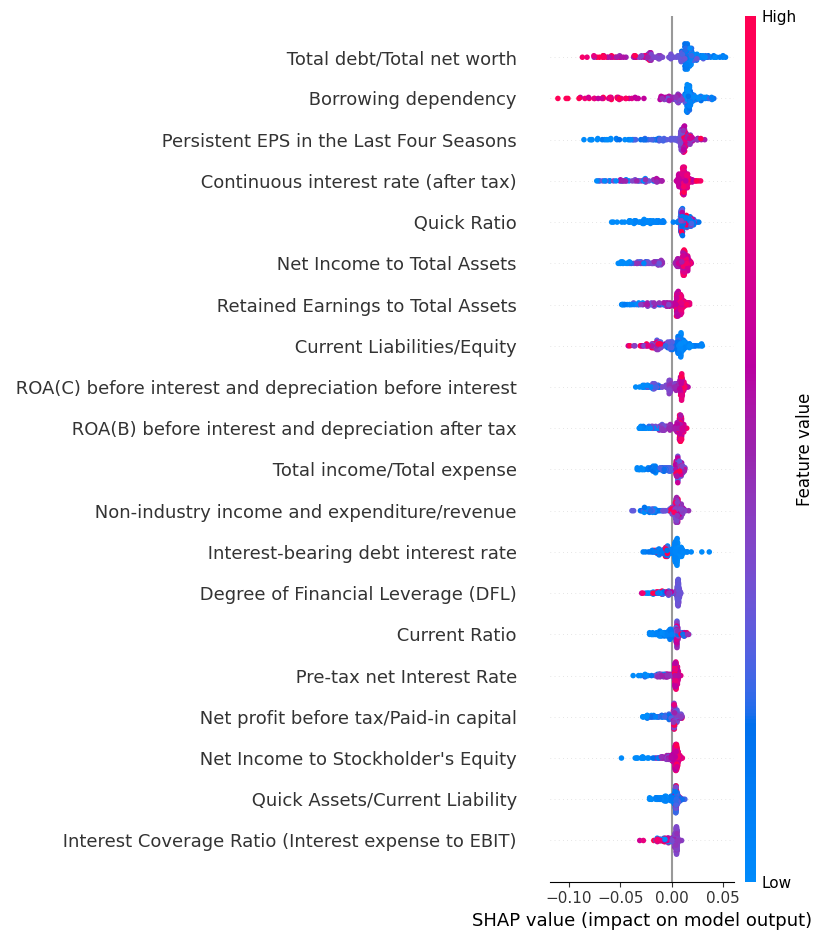

In [8]:
import shap

best_model_name = metrics_df.iloc[0]['Model']
best_model = models[best_model_name]

preprocessor = best_model.named_steps['pre']
clf = best_model.named_steps['clf']

X_train_proc = preprocessor.fit_transform(X_train, y_train)
X_shap_sample = X_train_proc[:200]

explainer = shap.Explainer(clf, X_shap_sample)
shap_values = explainer(X_shap_sample)

# SHAP summary plot
shap.summary_plot(shap_values[:,:,0], X_shap_sample, feature_names=selected_features)

# 8. Population Stability Index (PSI)

/tmp/ipython-input-2556690165.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


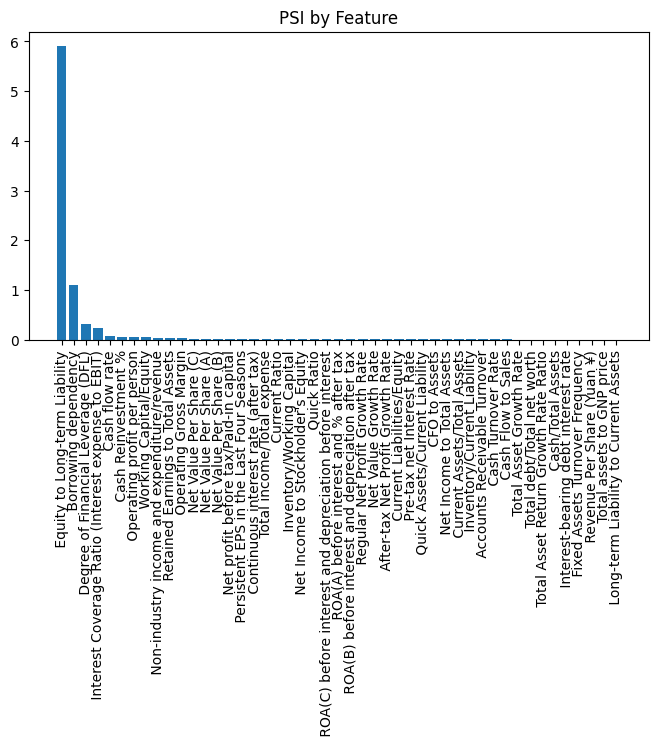

,Feature,PSI
40,Equity to Long-term Liability,5.900190
23,Borrowing dependency,1.098984
45,Degree of Financial Leverage (DFL),0.319611
46,Interest Coverage Ratio (Interest expense to ...,0.227965
7,Cash flow rate,0.077381


In [9]:
psi_values = []
for feat in X_train.columns:
    train_bins = pd.qcut(X_train[feat], q=10, duplicates="drop")
    test_bins = pd.cut(X_test[feat], bins=train_bins.cat.categories)
    train_dist = train_bins.value_counts(normalize=True)
    test_dist = test_bins.value_counts(normalize=True)
    psi = np.sum((train_dist - test_dist) * np.log((train_dist + 1e-6) / (test_dist + 1e-6)))
    psi_values.append((feat, psi))

psi_df = pd.DataFrame(psi_values, columns=["Feature", "PSI"]).sort_values("PSI", ascending=False)
plt.figure(figsize=(8,4))
plt.bar(psi_df["Feature"], psi_df["PSI"])
plt.title("PSI by Feature")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

psi_df.head()
